## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.qip.operations import *
from qutip.qip.circuit import *
import sys
sys.path.append('../SimulationCode/')
from BlindGatesSimulation import *
from fiber_network import FiberNetwork
from SiVnodes import SiV
from SiVgates import *
from Plots import *
import pandas as pd
import matplotlib as mpl




In [2]:
# colors for plots
c1 = '#F15F57'
c2 = '#F6851F'
c3 = '#FDB913'
c4 = '#743062'
c5 = '#C87EB5'
c6 = '#4CC0B3'
c7 = '#1C9AAA'

#### Define SiVs 

In [3]:
# Create SiVs:

#Server A, G12
siv_a = SiV(kappa_in= (74.9 - 54.5)*(10**3), kappa_w= (54.5)*(10**3), g=5.6*(10**3), wCav = (0)*(10**3), 
             wSiv = -(479.8 -639.6)*(10**3), dwEl = 0.5*(10**3)) # G12
#Server B, B16
siv_b = SiV(kappa_in= (43.5 - 26.0)*(10**3), kappa_w= (26.0)*(10**3), g=8.5*(10**3), wCav = (0)*(10**3), 
             wSiv = -(804.9 -657.6)*(10**3), dwEl = -0.5*(10**3)) # B16

### Setup single Node experiments in B16

In [4]:
# Create Networks:
b16_network = FiberNetwork(siv_b) # this device is now in B16 fridge

# Create Simulation:
sim = BlindComputing(b16_network)

In [5]:
# Setup efficiencies
fudge = 1

b16_network.fibercoupling_eff = 0.6*fudge
b16_network.tdi_eff = 0.35*0.3
b16_network.snspd_eff = 0.9
b16_network.detection_eff
b16_network.detection_eff_reset()

print('Detection efficientvy is = ', b16_network.detection_eff)

Detection efficientvy is =  0.0567


#### MW gates

In [6]:
# gate fidelities

b16_mwfid = 0.99
g12_mwfid = 1

#### Move the SiV to the desired contrast point

In [7]:
b16_contrast = 25 # range 18 - 30
g12_contrast = 20 # range 12 - 20

siv_b.set_contrast(b16_contrast)
actual_contrast_b16 = siv_b.get_best_contrast()
print("B16 contrast is set to = ", actual_contrast_b16)

new contrast 27.979731852612378
B16 contrast is set to =  27.979731852612378


In [8]:
el_initial_xp = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_xm = qt.ket2dm((qt.basis(2,0)- qt.basis(2,1)).unit())
el_initial_zp = qt.ket2dm(qt.basis(2, 0))
el_initial_ym = qt.ket2dm(qt.basis(2, 0)- 1j* qt.basis(2, 1)).unit()
el_initial_yp = qt.ket2dm(qt.basis(2, 0)+ 1j* qt.basis(2, 1)).unit()



## B16 single qubit rotations

In [113]:
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': - 0.1, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid, b16_mwfid] # default fidelities
               }
mu = 0.05

In [109]:
phi1 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
phi2 = 0
phi3 = 0
el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())

In [ ]:
cluster_state_length = 1
n_rounds = 10000

rates_apd1_apd2 = np.empty((0, 2), dtype=float)
rho_phi_n_array_s = np.empty((0, n_rounds, 2, 2), dtype=complex)
rho_phi_n_array_cl = np.empty((0, n_rounds, 2, 2), dtype=complex)
nxnynz_cl_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
nxnynz_s_phi_array =  np.empty((0, n_rounds, 3), dtype=float)
for j in range(len(phi1)):
    rho_n_array_cl = np.empty((0, 2, 2), dtype=complex)
    rho_n_array_s = np.empty((0, 2, 2), dtype=complex)
    rho_click = np.empty((0, 1), dtype=int)
    phi1e = phi1[j]
    print("Phi angle = ", phi1e)
    nxnynz_cl_array =  np.empty((0, 3), dtype=float)
    nxnynz_s_array =  np.empty((0, 3), dtype=float)
    for i in range(n_rounds): 
        if i%100 == 0:
            print(i)
        rho_init_xp = sim.single_node_electron_exp(el_initial_xp, imperfections, cluster_state_length, phi1e, phi1, phi3, mu)
        rho_n_item_s = rho_init_xp[0]
        rho_n_item_cl = (qt.sigmaz()**(rho_init_xp[1]))*rho_init_xp[0]*(qt.sigmaz()**(rho_init_xp[1]))
        rho_n_array_s = np.vstack([rho_n_array_s, [rho_n_item_s]])
        rho_n_array_cl = np.vstack([rho_n_array_cl, [rho_n_item_cl]])
        nxnynz_cl = calculate_bloch_components(rho_n_item_cl)
        nxnynz_s = calculate_bloch_components(rho_n_item_s)
        nxnynz_cl_array =  np.vstack([nxnynz_cl_array, [nxnynz_cl]])
        nxnynz_s_array =  np.vstack([nxnynz_s_array, [nxnynz_s]])
    nxnynz_cl_phi_array =  np.vstack([nxnynz_cl_phi_array, [nxnynz_cl_array]])
    nxnynz_s_phi_array =  np.vstack([nxnynz_s_phi_array, [nxnynz_s_array]])
    mean_cl_nxnynz = np.mean(nxnynz_cl_array, axis =0)
    std_cl_nxnynz = np.std(nxnynz_cl_array, axis =0)/np.sqrt(n_rounds)
    mean_s_nxnynz = np.mean(nxnynz_s_array, axis =0)
    std_s_nxnynz = np.std(nxnynz_s_array, axis =0)/np.sqrt(n_rounds)
    print(mean_cl_nxnynz, std_cl_nxnynz)
    print(mean_s_nxnynz, std_s_nxnynz)
    rates_apd1_apd2 = np.append(rates_apd1_apd2, [rho_init_xp[2:4]])

    rho_phi_n_array_s = np.vstack([rho_phi_n_array_s, [rho_n_array_s]])
    rho_phi_n_array_cl = np.vstack([rho_phi_n_array_cl, [rho_n_array_cl]])

In [118]:
fid_err_phi =  np.empty((0, 2), dtype=float)
fid_ave_phi =  np.empty((0, 2), dtype=float)
for j in range(len(phi1)):
    U = rz(phi1[j])
    el_rho_final_ideal = U*el_initial_xp*U.dag()
    fid_n =  np.empty((0, 2), dtype=float)
    for k in range(n_rounds):
        fid = (qt.fidelity(qt.Qobj(rho_phi_n_array_cl[j][k]), el_rho_final_ideal))**2
        fid_n = np.append(fid_n, fid)
    fid_ave = np.mean(fid_n, axis = 0)
    # this is only the variability of the measurement
    fid_ave_std = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))
    fid_ave_phi = np.append(fid_ave_phi, fid_ave)
    fid_err_phi = np.append(fid_err_phi, fid_ave_std)

In [136]:
print(np.mean(nxnynz_cl_phi_array, axis = 1))
print(np.std(nxnynz_cl_phi_array, axis = 1)/np.sqrt(n_rounds))
print(np.mean(nxnynz_s_phi_array, axis = 1))
print(np.std(nxnynz_s_phi_array, axis = 1)/np.sqrt(n_rounds))

[[ 0.91115257 -0.09011496 -0.0069548 ]
 [ 0.71044618  0.56911975 -0.01335258]
 [ 0.09455779  0.89694037 -0.00762512]
 [-0.58053426  0.69644991 -0.00639887]]
[[0.00095105 0.0003485  0.00325048]
 [0.00148431 0.00166445 0.00276787]
 [0.00318744 0.00040197 0.0019758 ]
 [0.00204214 0.00163996 0.00254271]]
[[ 0.3057609   0.00047353 -0.0069548 ]
 [ 0.31610002  0.00475654 -0.01335258]
 [ 0.30978769  0.0088627  -0.00762512]
 [ 0.315204   -0.00804258 -0.00639887]]
[[0.00863571 0.00096618 0.00325048]
 [0.00653335 0.00592941 0.00276787]
 [0.00120707 0.00897797 0.0019758 ]
 [0.00528554 0.00715453 0.00254271]]


In [120]:
fid = np.mean(fid_ave_phi, axis = 0)
fiderr = np.sqrt(np.sum(fid_err_phi**2)/len(fid_err_phi))
print('Fidelity over phi = ', fid, "+-",  fiderr)

Fidelity over phi =  0.9519808652203994 +- 0.00034877246933622664


#### Blindness

In [121]:
rho_ave_phi_array =  np.empty((0, 2, 2), dtype=float)
eigen_phi_std_array = np.empty((0, 2), dtype=float)
eig_eta_array = np.empty((0, 2), dtype=float)

mean_nxnynz = np.mean(nxnynz_s_phi_array, axis =1)
std_nxnynz = np.std(nxnynz_s_phi_array, axis =1)/np.sqrt(n_rounds)

# eigen ebnergies and uncertainties of rho of phis
eigen_phis = [(1/2)*(1 -np.sqrt(np.sum(mean_nxnynz**2, axis = 1))), (1/2)*(1 +np.sqrt(np.sum(mean_nxnynz**2, axis = 1)))]
eigen_phis_std = np.array([eigenvalue_uncertainty(mean_nxnynz[i], std_nxnynz[i]) for i in range(len(mean_nxnynz))])

rho_ave_phi_array = np.mean(rho_phi_n_array_s, axis = 1)
rho_ave_tot = np.mean(rho_ave_phi_array, axis = 0)
nxnynz_tot = np.array([calculate_bloch_components(qt.Qobj(rho_ave_tot))])
nxnynz_tot_std = np.sqrt(np.sum(eigen_phis_std**2))/len(eigen_phis_std)

# std of variability of eigenvalues of rho tot
std_eigen_tot = eigenvalue_uncertainty(nxnynz_tot.ravel(), [nxnynz_tot_std,nxnynz_tot_std,nxnynz_tot_std])
eigen_tot = np.abs(qt.Qobj(rho_ave_tot).eigenenergies())

hv_tot = qt.entropy_vn(qt.Qobj(rho_ave_tot)) - np.mean([qt.entropy_vn(qt.Qobj(rho)) for rho in rho_ave_phi_array])
rho_tot_sigma_lambdas = (std_eigen_tot, std_eigen_tot)
rho_tot_lambdas = (eigen_tot[0], eigen_tot[1])
rho_lambdas = list(zip(eigen_phis[0], eigen_phis[1]))
rho_sigma_lambdas =  [(value, value) for value in eigen_phis_std]

hv_std = holevo_bound_uncertainty(rho_tot_lambdas, rho_tot_sigma_lambdas, rho_lambdas, rho_sigma_lambdas)

print('Holevo bound is = ', hv_tot, hv_std)


Holevo bound is =  3.4100408453419107e-05 0.000983889713131907


## B16 universal single qubit rotations

#### Identity

In [12]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [0, 0, 0]

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

cluster_state_length = 3


In [13]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = el_initial_yp

rho_n_array_cl_id = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_id = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_id =  np.empty((0, 3), dtype=float)
nxnynz_s_array_id =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_id = np.vstack([rho_n_array_s_id, [rho_s]])
    rho_n_array_cl_id = np.vstack([rho_n_array_cl_id, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_id = np.vstack([nxnynz_cl_array_id, [nxnynz_cl]])
    nxnynz_s_array_id = np.vstack([nxnynz_s_array_id, [nxnynz_s]])
nxnynz_tot_cl_id = np.mean(nxnynz_cl_array_id, axis = 0)
nxnynz_tot_s_id = np.mean(nxnynz_s_array_id, axis = 0)
nxnynz_tot_std_cl_id = np.std(nxnynz_cl_array_id, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_id = np.std(nxnynz_s_array_id, axis = 0)/np.sqrt(n_rounds)

fid_ave_id = np.mean(fid_n, axis = 0)
fid_ave_std_id = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_id)
print(nxnynz_tot_std_cl_id)

print(nxnynz_tot_s_id)
print(nxnynz_tot_std_s_id)



print("Fidelity of a universal Identity gate = ", fid_ave_id, "+-", fid_ave_std_id)


[ 0.0209751   0.03679736 -0.04106512]
[0.06497432 0.0969613  0.04549769]
[-0.24344323  0.52177822  0.10535698]
[0.04754829 0.01927548 0.04190762]
Fidelity of a universal Identity gate =  0.7608891154831745 +- 0.009637740362343473


##### FIdelity of Identity

In [14]:
U_transform_ztoy = qt.Qobj([[1, 1j], [1j, 1]]) / (2 ** 0.5)
print(U_transform_ztoy*el_initial_yp*U_transform_ztoy.dag())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


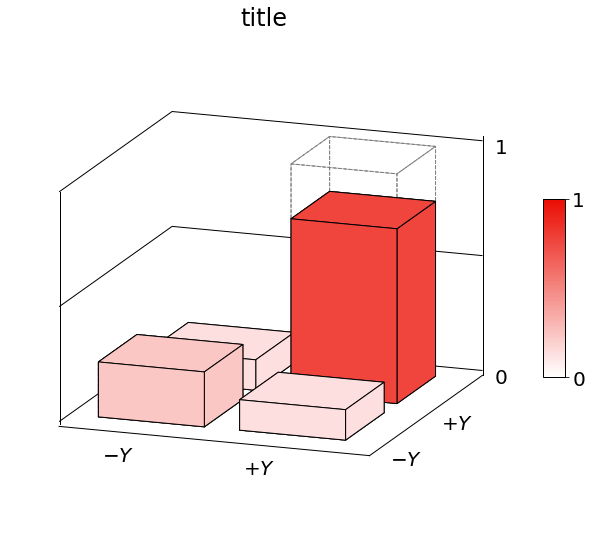

In [15]:
rho = np.mean(rho_n_array_cl_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

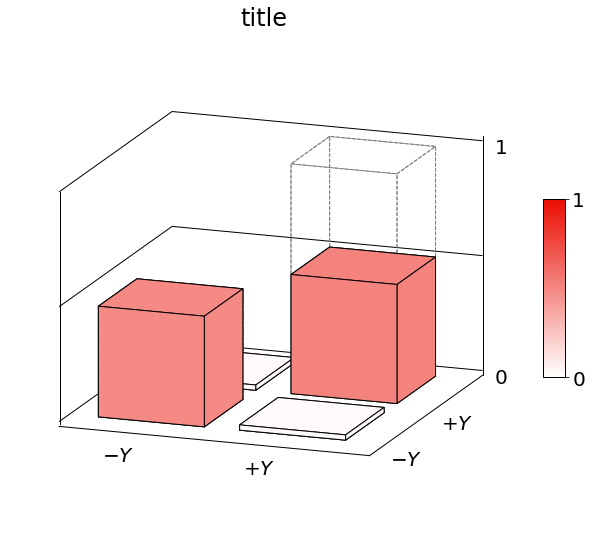

In [16]:
rho = np.mean(rho_n_array_s_id, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

#### Hadamart

In [17]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [np.pi/2, np.pi/2, np.pi/2]

el_initial_xp  = qt.ket2dm((qt.basis(2,0)+ qt.basis(2,1)).unit())
el_initial_yp  = qt.ket2dm((qt.basis(2,0)+ 1j*qt.basis(2,1)).unit())

cluster_state_length = 3


In [18]:
def single_qubit_universal_blind_gate_with_feedback(el_initial, imperfections, cluster_state_length, phi_array, mu):
    # define hadamart (it's not a true hadamart but it' sok we can keep track of signs as gate propogates)
    # Had_id = rx(-np.pi/2)

    fidel_values_pi_pi2 = {'pi': imperfections['mw_fid_num'][0],
                'pi_half': imperfections['mw_fid_num'][1]
                }
    gates = set_mw_fidelities(fid = imperfections['mw'], noise = imperfections['mw_noise'], fidel_val = fidel_values_pi_pi2)
    # make a hadamart from an imperfect pi/2
    Had = 1j*rx(np.pi)*gates['pi_half']


    measurement_outputs = np.empty((0, 4), dtype=float)
    rho = el_initial
    mi = np.round(0, 1)
    for i in range(cluster_state_length): 
        angle =  ((-1)**(mi))*phi_array[i]
        rho_after_SPG = sim.single_rotation_electron(rho, imperfections, angle, mu)
        # print(i, 'rho_after_SPG', rho_after_SPG)
        if i < 2:
            rho = Had*rho_after_SPG[0]*Had.dag()
            # print('after hadamard ', rho)
        else:
            rho = rho_after_SPG
            # print('raw final ', rho)

        mi = np.round(rho_after_SPG[1::],1)[0]
        measurement_outputs = np.array(np.vstack([measurement_outputs, [np.round(rho_after_SPG[1::],1)]]))
        
    
    rho_raw = rho[0]

    measurement_outputs = np.round(measurement_outputs[:,0], 1)
    rho_corrected = correction_single_qubit_universal_blind_gate_withfeedback(rho_raw, measurement_outputs)
    return rho_raw, rho_corrected, measurement_outputs

def correction_single_qubit_universal_blind_gate_withfeedback(rho_raw, measurement_outputs):
    
    # final correction: Z gate
    
    #for yp init identity
    sz = measurement_outputs[0]+ measurement_outputs[2] + 0*measurement_outputs[1]
    sx = measurement_outputs[1]
    rho_corr = ((qt.sigmaz()**(sz))*(qt.sigmax()**sx)*rho_raw*((qt.sigmax()**sx).dag())*((qt.sigmaz()**(sz)).dag()))
    
    # # for yp init had
    # sz = measurement_outputs[0]+ measurement_outputs[2] + measurement_outputs[1]
    # sx = measurement_outputs[1]
    # rho_corr = ((qt.sigmaz()**(sz))*(qt.sigmax()**sx)*rho_raw*((qt.sigmax()**sx).dag())*((qt.sigmaz()**(sz)).dag()))
    

    # for xp init need different correction

    return rho_corr

In [19]:
n_rounds = 30 # estimate for 6 hrs of run
el_rho_final_ideal = el_initial_ym


rho_n_array_cl_had = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_had = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_had =  np.empty((0, 3), dtype=float)
nxnynz_s_array_had =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_had = np.vstack([rho_n_array_s_had, [rho_s]])
    rho_n_array_cl_had = np.vstack([rho_n_array_cl_had, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_had = np.vstack([nxnynz_cl_array_had, [nxnynz_cl]])
    nxnynz_s_array_had = np.vstack([nxnynz_s_array_had, [nxnynz_s]])
nxnynz_tot_cl_had = np.mean(nxnynz_cl_array_had, axis = 0)
nxnynz_tot_s_had = np.mean(nxnynz_s_array_had, axis = 0)
nxnynz_tot_std_cl_had = np.std(nxnynz_cl_array_had, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_had = np.std(nxnynz_s_array_had, axis = 0)/np.sqrt(n_rounds)

fid_ave_had = np.mean(fid_n, axis = 0)
fid_ave_std_had = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_had)
print(nxnynz_tot_std_cl_had)

print(nxnynz_tot_s_had)
print(nxnynz_tot_std_s_had)

print("Fidelity of a universal Identity gate = ", fid_ave_had, "+-", fid_ave_std_had)


[-0.03484175  0.06004803 -0.08079803]
[0.08530355 0.08639919 0.06011945]
[ 0.05063875 -0.44961226 -0.06635656]
[0.08503931 0.02909707 0.06070573]
Fidelity of a universal Identity gate =  0.7248061344821232 +- 0.01454853537058549


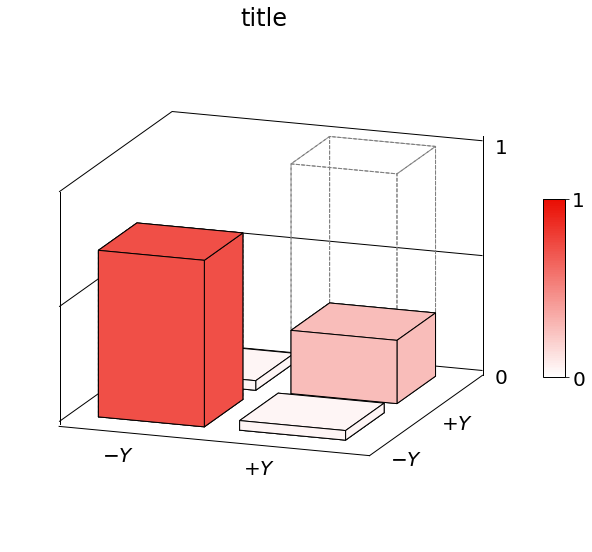

In [20]:
rho = np.mean(rho_n_array_cl_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

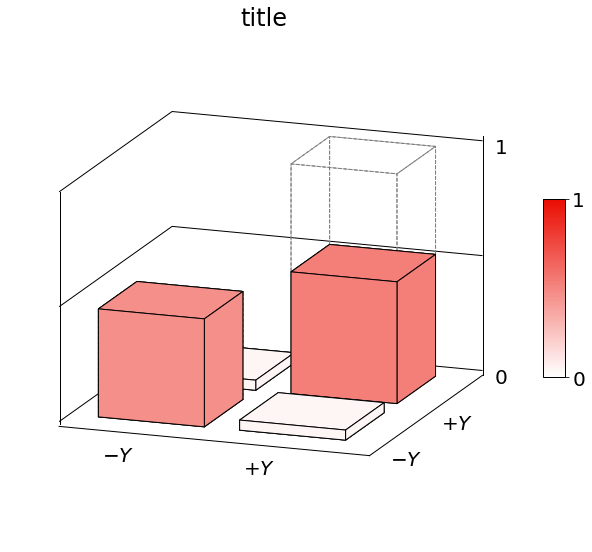

In [21]:
rho = np.mean(rho_n_array_s_had, axis = 0)
# from Z to Y basis
rho_y = U_transform_ztoy * rho * U_transform_ztoy.dag()
plot_from_rho_Identity(rho_y, "title", "filename", 'Blues')

#### T sqrt(X) T

In [22]:
b16_mwfid_unitary = 0.99
imperfections ={'contrast_noise': 0, #(0 not noisy or 1 noisy)
                'contrast': 'real', #'real'
                'tdinoise': 0.4, #np.pi/25, #'real'
                'mw': 'real', # or perfect
                'mw_noise': 1, #(0 is stable or 1 noisy/underotates overroates every experimental shot)
                'mw_fid_num': [b16_mwfid_unitary, b16_mwfid_unitary] # default fidelities
               }
mu = 0.3
phi_array  = [np.pi/4, np.pi/2, np.pi/4]

cluster_state_length = 3


In [23]:
TsqXT = rz(np.pi/4)*rx(np.pi/2)*rz(np.pi/4)
el_rho_final_ideal = TsqXT*el_initial_yp*TsqXT.dag()
print(el_rho_final_ideal)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.85355339+0.j   -0.25      +0.25j]
 [-0.25      -0.25j  0.14644661+0.j  ]]


In [24]:
n_rounds = 30 # estimate for 6 hrs of run

rho_n_array_cl_txt = np.empty((0, 2, 2), dtype=complex)
rho_n_array_s_txt = np.empty((0, 2, 2), dtype=complex)
nxnynz_cl_array_txt =  np.empty((0, 3), dtype=float)
nxnynz_s_array_txt =  np.empty((0, 3), dtype=float)
fid_n =  np.empty((0, 2), dtype=float)

for i in range(n_rounds):
    # if i%100==0:
    #     print(i)
    rho_output = single_qubit_universal_blind_gate_with_feedback(el_initial_yp, imperfections, cluster_state_length, phi_array, mu)
    rho_s = rho_output[0]
    rho_cl = rho_output[1]
    rho_n_array_s_txt = np.vstack([rho_n_array_s_txt, [rho_s]])
    rho_n_array_cl_txt = np.vstack([rho_n_array_cl_txt, [rho_cl]])
    fid = (qt.fidelity(qt.Qobj(rho_cl), el_rho_final_ideal))**2
    fid_n = np.append(fid_n, fid)
    nxnynz_cl = calculate_bloch_components(rho_s)
    nxnynz_s = calculate_bloch_components(rho_cl)
    nxnynz_cl_array_txt = np.vstack([nxnynz_cl_array_txt, [nxnynz_cl]])
    nxnynz_s_array_txt = np.vstack([nxnynz_s_array_txt, [nxnynz_s]])
nxnynz_tot_cl_txt = np.mean(nxnynz_cl_array_txt, axis = 0)
nxnynz_tot_s_txt = np.mean(nxnynz_s_array_txt, axis = 0)
nxnynz_tot_std_cl_txt = np.std(nxnynz_cl_array_txt, axis = 0)/np.sqrt(n_rounds)
nxnynz_tot_std_s_txt = np.std(nxnynz_s_array_txt, axis = 0)/np.sqrt(n_rounds)

fid_ave_txt = np.mean(fid_n, axis = 0)
fid_ave_std_txt = np.std(fid_n, axis = 0)/(np.sqrt(n_rounds))

print(nxnynz_tot_cl_txt)
print(nxnynz_tot_std_cl_txt)

print(nxnynz_tot_s_txt)
print(nxnynz_tot_std_s_txt)

print("Fidelity of a universal Identity gate = ", fid_ave_txt, "+-", fid_ave_std_txt)


[-0.06349198  0.10913251 -0.01233823]
[0.0647671  0.08790498 0.0811155 ]
[-0.25623941 -0.44462591  0.29509847]
[0.04626587 0.03917323 0.06067972]
Fidelity of a universal Identity gate =  0.7795493984301064 +- 0.024851947506814232


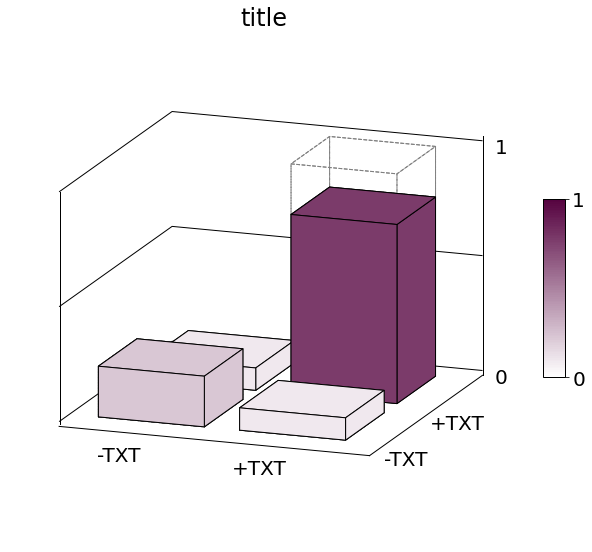

In [28]:
rho = np.mean(rho_n_array_cl_txt, axis = 0)
# to TXTy basis 
U_txt = U_transform_ztoy*TsqXT.dag()
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_magic(rho_y, "title", "filename", 'Blues')

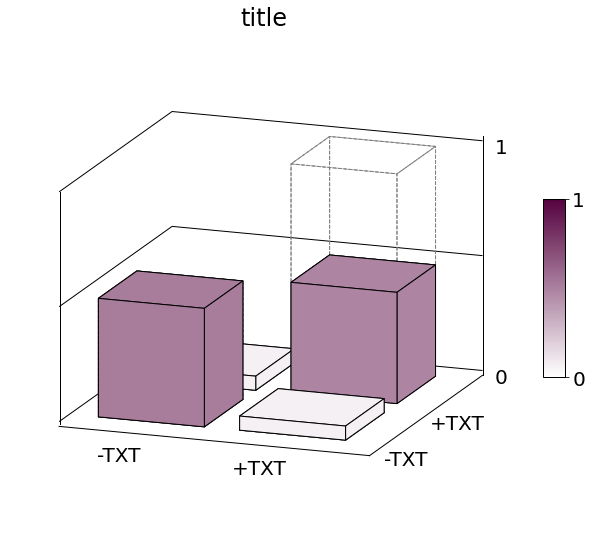

In [29]:
rho = np.mean(rho_n_array_s_txt, axis = 0)
# from Z to Y basis
rho_y = U_txt*rho*U_txt.dag()
plot_from_rho_magic(rho_y, "title", "filename", 'Blues')

#### Blindness for the universal single qubit gate

## B16 Intranode two-qubit gate 